In [1]:
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Utils

In [2]:
def getTrainMaxSpeed(train_id):
    train_id = str(train_id)
    if train_id[0].isdigit():
        return "80"
    elif train_id[0].isalpha():
        if train_id[0] == "G" or train_id[0] == "C":
            return "350"
        elif train_id[0] == "D":
            return "260"
        elif train_id[0] == "Z" or train_id[0] == "T":
            return "160"
        else:
            return "120"

In [3]:
def convertTimetoMinute(time, day):
    try:
        time_float = float(time)
        # Convert the fraction of a day to a timedelta object
        delta = timedelta(days=time_float)
        start_of_day = datetime(year=1, month=1, day=1)
        time = start_of_day + delta
    except:
        pass

    if day == "Day 1":
        minutes = time.hour * 60 + time.minute
    elif day == "Day 2":
        minutes = time.hour * 60 + time.minute + 24 * 60
    elif day == "Day 3":
        minutes = time.hour * 60 + time.minute + 24 * 60 * 2
    elif day == "Day 4":
        minutes = time.hour * 60 + time.minute + 24 * 60 * 3

    return minutes

# Network Construction

## Mutli Directed Network

In [4]:
df = pd.read_excel('../data/Railway Data_JL.xlsx')
df

train  st_no  st_id   date  arr_time  dep_time stay_time mileage  \
0      1095      1    692  Day 1  19:06:00  19:06:00         -       0   
1      1095      2   1351  Day 1  19:27:00  19:32:00         5      27   
2      1095      3    698  Day 1  19:59:00  20:01:00         2      63   
3      1095      4    944  Day 1  20:31:00  20:35:00         4     108   
4      1095      5    232  Day 1  21:00:00  21:04:00         4     139   
...     ...    ...    ...    ...       ...       ...       ...     ...   
69633   Z97      1    390  Day 1  13:00:00  13:00:00         -       0   
69634   Z97      2   2175  Day 1  18:41:00  18:47:00         6     707   
69635   Z97      3   1374  Day 1  23:16:00  23:22:00         6    1243   
69636   Z97      4   2265  Day 2  02:35:00  02:41:00         6    1605   
69637   Z97      5    952  Day 2  10:01:00  10:01:00         -    2320   

             lat         lon  
0      37.860480  112.586820  
1      37.697190  112.731180  
2      37.421360  112.570320  
3      37.206610  112.168470  
4      37.018470  111.919060  
...          ...         ...  
69633  39.896042  116.321152  
69634  34.746610  113.659410  
69635  30.528640  114.317010  
69636  28.200063  113.019529  
69637  23.149242  113.324364  

[69638 rows x 10 columns]

In [5]:
time_obj = datetime.strptime('0:53:18', '%H:%M:%S')
convertTimetoMinute(time_obj, "Day 1")

53

### Without outliers time datas (ex: 0.8884 and not 0:53:18)

In [6]:
G = nx.MultiDiGraph()
G

In [7]:
st_no_comp = 0
prev_node = 0
prev_mileage = 0
prev_dep_time = 0
for index, row in df.iterrows():
    if not G.has_node(row["st_id"]):
        G.add_node(row["st_id"], pos=(row["lon"], row["lat"]))
    if row["st_no"] == st_no_comp:
        G.add_edge(prev_node, row["st_id"], arr_time=convertTimetoMinute(row["arr_time"], row["date"]), dep_time=prev_dep_time, train=row["train"], train_max_speed=getTrainMaxSpeed(row["train"]), day=row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]
        prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
    else:
        prev_dep_time = convertTimetoMinute(row["dep_time"], row["date"])
        st_no_comp = row["st_no"] + 1
        prev_node = row["st_id"]
        prev_mileage = row["mileage"]


In [8]:
G.number_of_nodes()

2719

In [9]:
G.number_of_edges()

64155

In [10]:
for node in list(G.nodes):
    print(node, G.out_edges(node))

692 [(692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 1351), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 689), (692, 691), (692, 691), (692, 691), (692, 691), (692, 691), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 226), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1771), (692, 1110), (692, 1110), (692, 1110), (692, 2289), (692, 2289), (692, 2289), (692, 2289), (692, 

In [11]:
for edge in list(G.edges):
    print(edge,G[edge[0]][edge[1]][edge[2]]["day"], G[edge[0]][edge[1]][edge[2]]["dep_time"], G[edge[0]][edge[1]][edge[2]]["arr_time"], G[edge[0]][edge[1]][edge[2]]["train"], G[edge[0]][edge[1]][edge[2]]["train_max_speed"])

(692, 1351, 0) Day 1 1146 1167 1095 80
(692, 1351, 1) Day 1 893 914 1485 80
(692, 1351, 2) Day 1 1170 1192 1551 80
(692, 1351, 3) Day 1 1170 1192 1554 80
(692, 1351, 4) Day 2 1722 1743 2462 80
(692, 1351, 5) Day 2 1722 1743 2463 80
(692, 1351, 6) Day 1 1370 1391 2671 80
(692, 1351, 7) Day 1 437 458 2673 80
(692, 1351, 8) Day 1 878 899 6032 80
(692, 1351, 9) Day 1 390 422 6034 80
(692, 1351, 10) Day 1 762 783 K1885 120
(692, 1351, 11) Day 1 762 783 K1888 120
(692, 1351, 12) Day 1 1410 1431 K237 120
(692, 1351, 13) Day 1 1410 1431 K240 120
(692, 1351, 14) Day 2 1928 1949 K609 120
(692, 1351, 15) Day 1 527 548 K689 120
(692, 1351, 16) Day 2 1910 1932 K865 120
(692, 1351, 17) Day 2 1910 1932 K868 120
(692, 1351, 18) Day 1 708 729 K902 120
(692, 1351, 19) Day 1 708 729 K903 120
(692, 689, 0) Day 1 1388 1394 2461 80
(692, 689, 1) Day 1 1388 1394 2464 80
(692, 689, 2) Day 2 2008 2014 2672 80
(692, 689, 3) Day 1 509 515 4616 80
(692, 689, 4) Day 1 1010 1015 4636 80
(692, 689, 5) Day 1 390 395 

## Simplified Single Directed network

In [12]:
SG = G

for edge in list(SG.edges):
    if edge[2] != 0:
        SG.remove_edge(edge[0], edge[1], key=edge[2])

In [13]:
SG.number_of_nodes()

2719

In [14]:
SG.number_of_edges()

10789

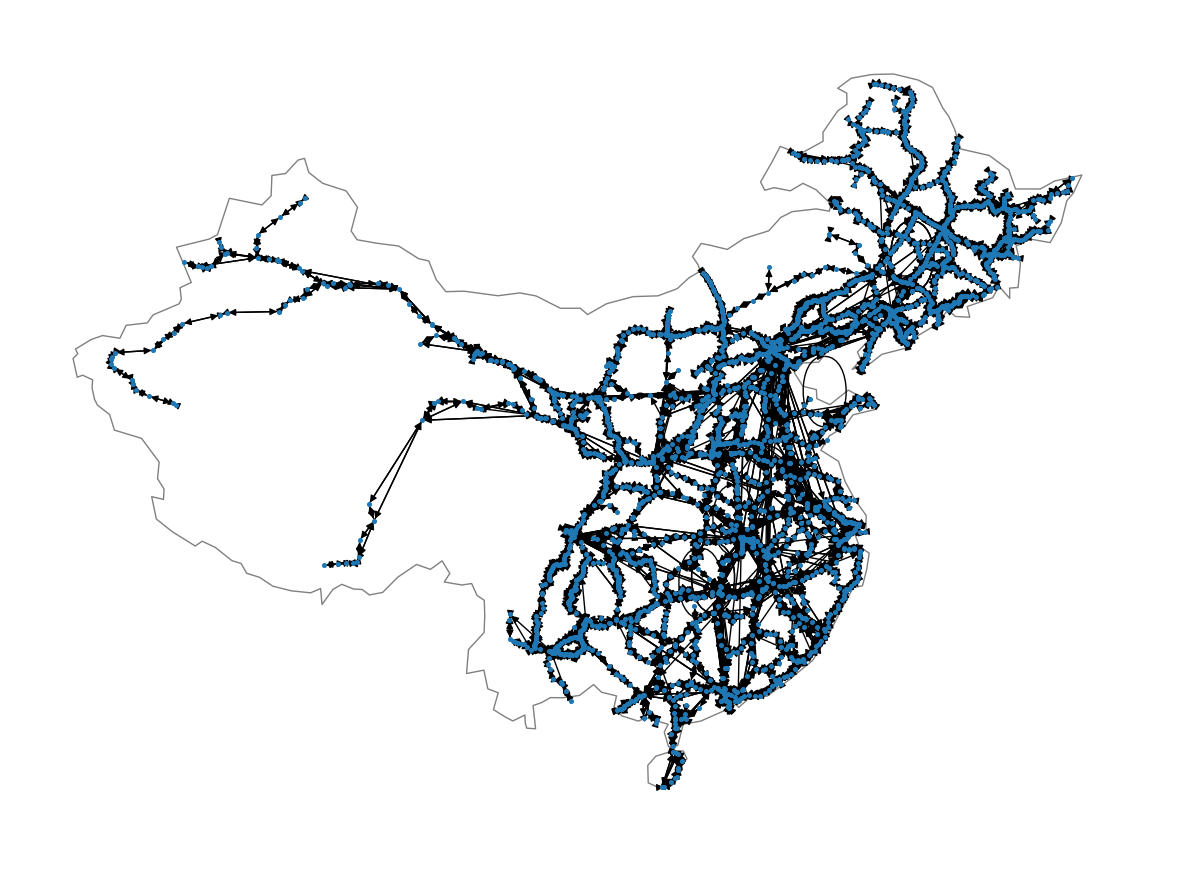

In [15]:
pos = nx.get_node_attributes(SG, 'pos')
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw(SG,pos,node_size=7, width=1 )

## Undirected network only spatial

In [16]:
SG = SG.to_undirected(reciprocal=False)

In [17]:
SG.number_of_nodes()

2719

In [18]:
SG.number_of_edges()

6173

In [19]:
for edge,data in list(SG.nodes(data=True)):
    print(edge, data)

692 {'pos': (112.58682, 37.86048)}
1351 {'pos': (112.731179999999, 37.6971899999999)}
698 {'pos': (112.57032, 37.42136)}
944 {'pos': (112.16847, 37.2066099999999)}
232 {'pos': (111.91906, 37.01847)}
1639 {'pos': (111.771019999999, 36.86171)}
2335 {'pos': (111.71973, 36.58583)}
1512 {'pos': (111.67162, 36.26214)}
127 {'pos': (111.53682, 36.0868299999999)}
259 {'pos': (111.3585, 35.6131299999999)}
1835 {'pos': (110.99518, 35.6126999999999)}
1480 {'pos': (110.72605, 35.58776)}
2362 {'pos': (110.44188, 35.48393)}
503 {'pos': (110.09119, 35.19518)}
1009 {'pos': (109.40295, 34.77167)}
2058 {'pos': (108.96283, 34.27727)}
802 {'pos': (107.15321, 34.37297)}
681 {'pos': (105.8986, 34.56586)}
1704 {'pos': (105.33231, 34.7629299999999)}
2314 {'pos': (104.70544, 34.9523799999999)}
314 {'pos': (103.8512, 36.03493)}
783 {'pos': (104.62502, 35.5921499999999)}
542 {'pos': (108.73483, 34.3438799999999)}
1148 {'pos': (111.21098, 35.61045)}
683 {'pos': (117.209464999999, 39.134968)}
983 {'pos': (116.70567

In [20]:
pos = nx.get_node_attributes(SG, 'pos')

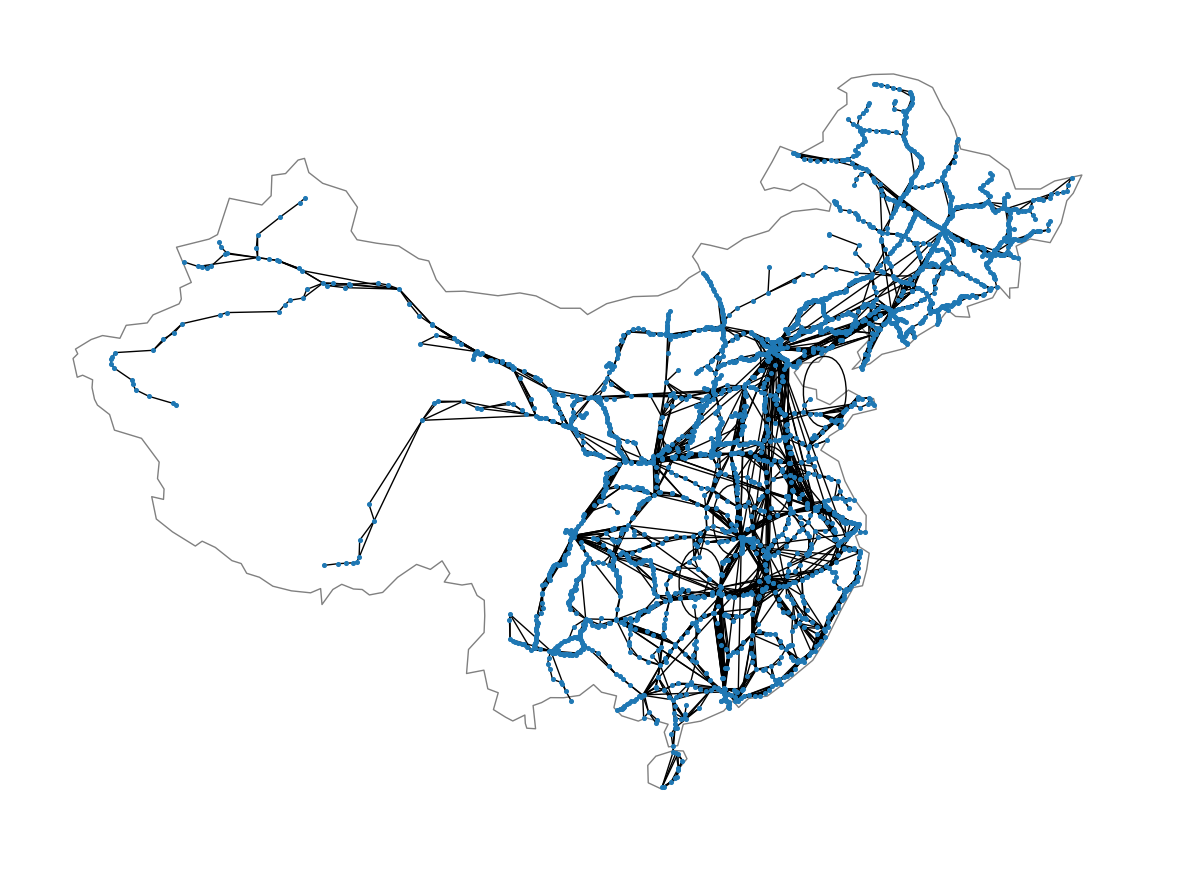

In [21]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw(SG,pos,node_size=7, width=1 )

## Animated graph

In [22]:
# Import slider package
from matplotlib.widgets import Slider

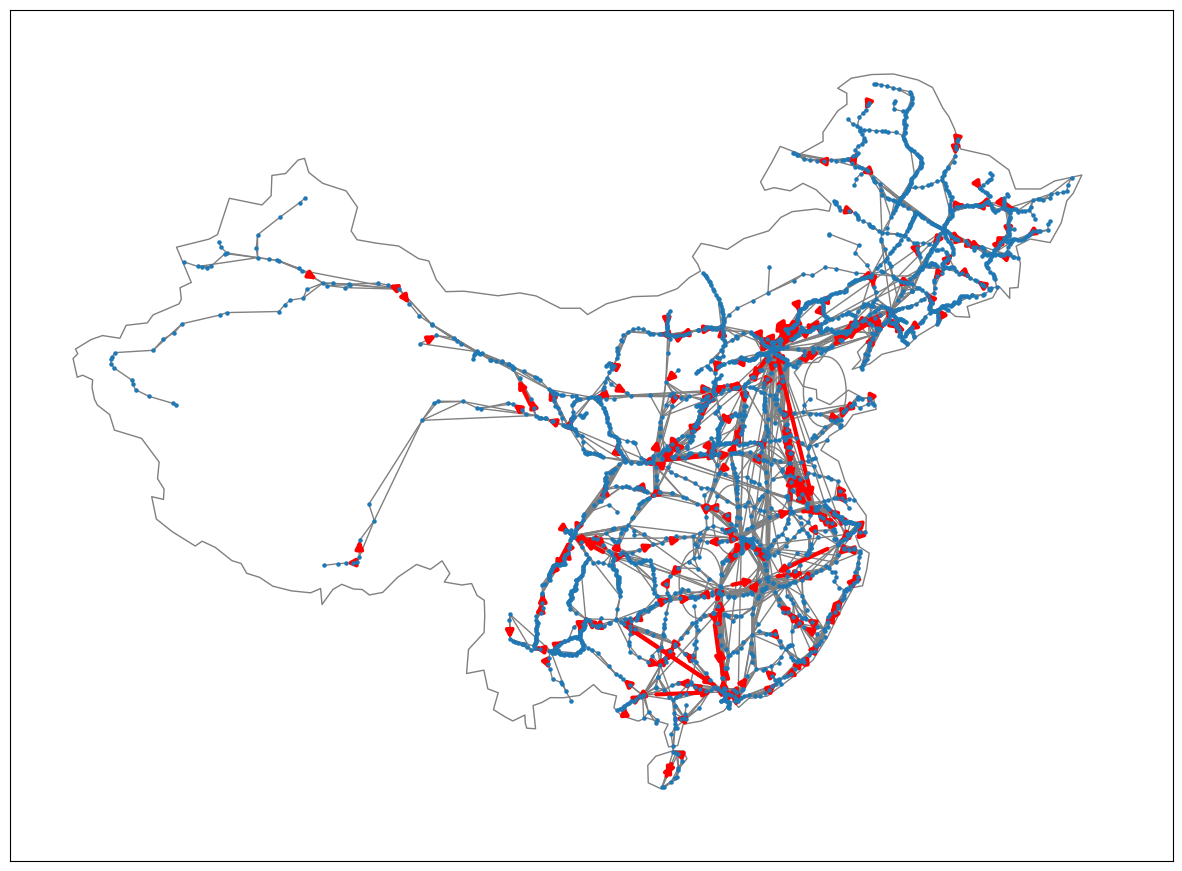

In [23]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]
china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
nx.draw_networkx_nodes(SG,pos,node_size=5)
nx.draw_networkx_edges(SG,pos, width=1, edge_color="grey")
G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < 600 and attr['arr_time'] > 600))
nx.draw_networkx_edges(G2,pos, width=3, edge_color="red")

In [24]:
G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < 600 and attr['arr_time'] > 600))

In [25]:
G2.number_of_nodes()

446

In [26]:
G2.number_of_edges()

292

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()

min_slider = min(list(nx.get_edge_attributes(G, 'dep_time').values()))
max_slider = max(list(nx.get_edge_attributes(G, 'arr_time').values()))

int_range = widgets.IntSlider(min=min_slider, max=max_slider, step=10, value=max_slider/2)
output2 = widgets.Output()

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
china = world[world["name"] == "China"]

display(int_range, output2)

def on_value_change(change):
    with output2:
        ax.clear()
        G2 = nx.DiGraph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['dep_time'] < change['new'] and attr['arr_time'] > change['new']))
        china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15),ax=ax)
        nx.draw_networkx_nodes(SG,pos,node_size=1, ax=ax)
        nx.draw_networkx_edges(G2,pos, width=1, edge_color="red",ax=ax)
        plt.show()

int_range.observe(on_value_change, names='value')

# china.plot(linewidth=1, edgecolor="grey", facecolor="white", figsize=(15,15))
# nx.draw_networkx_nodes(SG,pos,node_size=5)
# nx.draw_networkx_edges(SG,pos, width=1, edge_color="grey")
# nx.draw_networkx_edges(G2,pos, width=3, edge_color="red")



In [28]:
# When using the `widget` backend from ipympl,
# fig.canvas is a proper Jupyter interactive widget, which can be embedded in
# an ipywidgets layout. See https://ipywidgets.readthedocs.io/en/stable/examples/Layout%20Templates.html

# One can bound figure attributes to other widget values.
from ipywidgets import AppLayout, FloatSlider
import numpy as np

plt.ioff()

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=1.0,
    min=0.02,
    max=2.0
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
plt.title('Plotting: y=sin({} * x)'.format(slider.value))

x = np.linspace(0, 20, 500)

lines = plt.plot(x, np.sin(slider.value * x))

def update_lines(change):
    plt.title('Plotting: y=sin({} * x)'.format(change.new))
    lines[0].set_data(x, np.sin(change.new * x))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AttributeError: 'FigureCanvasNbAgg' object has no attribute 'layout'